In [0]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import pandas as pd
import scipy.stats

# Parameter Estimation for an altered Lotka-Volterra Equations

Following the framework we have preivously developed:

 - ODE model as described below
 - Multivariate Normal Noise Model
 - Normal Priors for our Parameters
 
### ODE Model
 $$
\begin{aligned}
  \dot x&=-(-0.15\,(a -0.5)^2 + 2)x + xy \\
  \dot y&=y - xy \\
\end{aligned}
 $$
 Has a solution $\boldsymbol{x}(t) = (V(t), R(t))$ at time $t$.

### Noise Model
We will simplify our noise model so that there is independence between the parameters we are trying to infer from. This is done by having a diagonal matrix in our mutlivariate normal distribution, as shown below.

If $\boldsymbol{y_i}$ is an observation of both spacial variabels our system at time $t_i$, then we our noise model is:

$$ \boldsymbol{y_i} \mid \boldsymbol{\theta} \sim N( \boldsymbol{x}(t_i , \boldsymbol{\theta}), \Sigma), \qquad 
\Sigma = \begin{bmatrix}
\sigma_1^2 & 0 \\
0 & \sigma_2^2 
\end{bmatrix}  $$

### Prior for Parameters

We will be performing inference on $\boldsymbol{\theta} = a$. As above, we simply the prior so that the parameters are independent apriori (and therefore aposteriori).

$$ \boldsymbol{\theta}\sim N( \boldsymbol{\mu}, \Delta), \qquad 
\Delta = 0.1 $$


### Inference 
Since we will be using the Metropolis Hastings (MH) algorithm to sample from the posterior, we do not need to calculate the evidence term in Bayes Formula. Our posterior is therefore:

$$ p(\boldsymbol{\theta} \mid \boldsymbol{y}) \propto p(\boldsymbol{\theta}) \: \prod_{i = 1}^{m} p(\boldsymbol{y}_i \mid \boldsymbol{\theta}) $$

For numerical stability, we will be using the log likelihood.

### Construction of Parameters in ODE model.

For this example, I would like to explore how the MH algorithm fares with mutli-modal distributions. To try and create a mutli-modal posterior, I have altered the Lotka-Volterra to depend on a funciton of a parameter, that is:

$$ \dot x = -g(a)\,x + xy ,\quad \text{where} \quad g(a)  =-0.15\,(a -0.5)^2 + 2 $$

This is so that we have a two values of $a$ which could give rise to the data due the symmetry of $g(a)$ around $a=\frac{1}{2}$. I believe this should give to a bi-modal likelihood distribution.

In [0]:
def dX_dt(X, t, a):
    Xdot = np.empty((2,))
    Xdot[0] = -(-0.15*(a-0.5)**2 +2)*X[0] + X[0]*X[1]
    Xdot[1] = X[1] - X[0]*X[1]
    return Xdot

I have constructed the $g(a)$ function in our ODE system so that we will obtain a bi-modal posterior distribution. There are two ways in which we can introduce multimodality into our posterior, through the prior distribution or through the likelihood. I have chosen to work with introducing it through the likelihood function. 

To create this bi-modality, I have created the parameter function $g(a)$ so that we have $g(a_1) = g(a_2) $ where $a_1 \neq a_2$ and $a_1$ and $a_2$ are sufficently far apart that we create bi-modality (this distance depends on the varance of the noise model). With this set up, both $a_1$ and $a_2$ will produce the same numerical solution when we integrate.

As a result, $p(\boldsymbol{y} \mid a_1) = p(\boldsymbol{y} \mid a_2)$

### Plotting g(a)

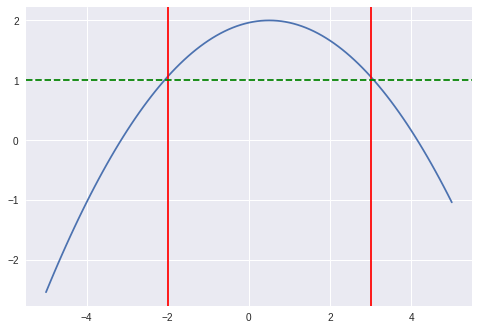

In [64]:
a_grid = np.linspace(-5,5, 101)
g_a =-0.15*(a_grid-0.5)**2 +2
plt.plot(a_grid, g_a)
plt.axvline(x = -2, color = 'r')
plt.axvline(x = 3, color = 'r')
plt.axhline(y = 1, color = 'g', linestyle = '--')
plt.show()

In [0]:
a = -2
initial_X = [2, 1]

t = np.linspace(0, 50, 101)
output = integrate.odeint(dX_dt, initial_X, t, args = (a,))

In [0]:
sol_df = pd.DataFrame(index = t)
sol_df['x'] = output[:, 0]
sol_df['y'] = output[:, 1]

In [0]:
#Creating the simulated dataframe

sim_df = pd.DataFrame(index = t)

mean, scale = 0, 0.1

x_experiment  = [sol + np.random.normal(0, scale) for sol in sol_df["x"]]
y_experiment  = [sol + np.random.normal(0, scale) for sol in sol_df["y"]]

sim_df['x'] = x_experiment
sim_df['y'] = y_experiment

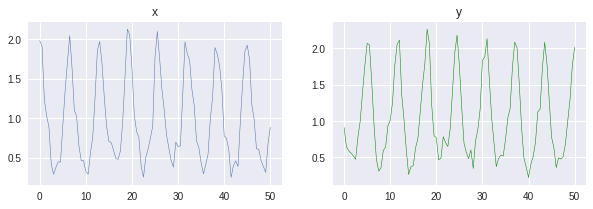

In [11]:
f = plt.figure(figsize=(10,3))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(sim_df["x"], linewidth = 0.5)
ax.set_title("x")
ax2.plot(sim_df["y"], color = 'g', linewidth = 0.5)
ax2.set_title("y")

plt.show()

In [0]:
#Prior Distribution

Delta = np.array([[3.0, 0],
                  [0, 3.0]])

mu = np.array([0])

def prior(theta):
    return scipy.stats.norm.pdf(theta, mu, 3.0)

In [0]:
#Likelihood/Noise Model

Sigma = np.array([[0.1, 0],
                  [0, 0.1]])

def diff_eqn_soln(theta, initial_X, t):
    output = integrate.odeint(dX_dt, initial_X, t, args = (theta,))
    proposed_df = pd.DataFrame(index = t)
    proposed_df['x'] = output[:, 0]
    proposed_df['y'] = output[:, 1]
    return proposed_df

def log_likelihood(theta, sim_df, Sigma, initial_X, t):
    likelihood_sum = 0
    proposed_df = diff_eqn_soln(theta, initial_X, t)
    for index, obs in sim_df.iterrows():
        likelihood_sum = likelihood_sum + np.log(scipy.stats.multivariate_normal.pdf(sim_df.loc[index], proposed_df.loc[index], Sigma))
    return likelihood_sum

def posterior(theta, sim_df, Sigma, initial_X, t):
    return np.exp(log_likelihood(theta, sim_df, Sigma, initial_X, t))*prior(theta)

#Proposal Distribution

sd = 0.7
def q(theta):
    return scipy.stats.norm.rvs(theta, sd)

In [0]:
#MH Algorithm

def MH_algorithm(X_0, no_of_cycles, sim_df):
    import time
    
    trace_hist = pd.DataFrame(columns = ['a'])
    trace_hist = trace_hist.append(pd.DataFrame([X_0], columns = ['a']))
    time_hist = []
    X_t = X_0
    for i in range(no_of_cycles):
        start = time.time()
        #Generate a new move using our proposal distribution
        Y_t = q(X_t)
        #Calculate the posterior for both X_t and Y_t then compare
        p_X = posterior(X_t, sim_df, Sigma, initial_X, t)
        p_Y = posterior(Y_t, sim_df, Sigma, initial_X, t)
        #Compare and accept move based on M-H acceptance rule
        comparison = p_Y/p_X
        alpha = min(comparison, 1.0)
        #Generate a random number between 0 and 1 to determine if we accept or reject the move
        rand_num = np.random.uniform(0,1)
        if alpha > rand_num:
            X_new = Y_t
        else:
            X_new = X_t
        trace_hist = trace_hist.append(pd.DataFrame([X_new], columns = ['a']))
        X_t = X_new
        end = time.time()
        time_hist.append(end - start)
    print("Completed: " + str(no_of_cycles) + " cycles")
    trace_hist = trace_hist.reset_index()
    trace_hist = trace_hist.drop(["index"], axis=1)
    return trace_hist , time_hist
    

In [44]:
import time
start = time.time()
trace, time_hist = MH_algorithm(0, 10000, sim_df)
end = time.time()
print("MH algorithm took: " + str(end - start) + "seconds to complete")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


Completed: 10000 cycles
MH algorithm took: 1079.2014701366425seconds to complete


### Traceplot

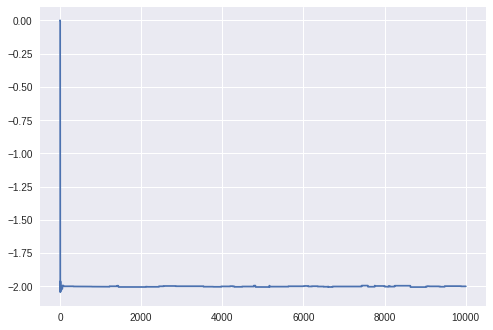

In [45]:
plt.plot(trace["a"])

### Grid Approximation

In [47]:
a_grid = np.linspace(-5,5, 101)
a_post = pd.DataFrame(index = a_grid)

a_post_vals = []
for a in a_grid:
    a_post_vals.append(posterior(a, sim_df, Sigma, initial_X, t))
    
a_post['post'] = a_post_vals

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


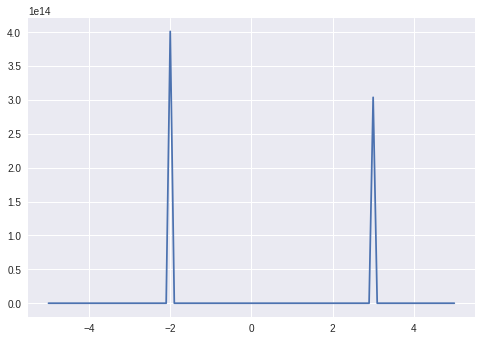

In [48]:
plt.plot(a_post)

We see that in the grid approximaiton, we obtain a bi-modal posterior distribution with two narrow peaks. Because these peaks are so narrow, our MH algorithm did not explore the second peak at $a=3$ and because of the constan variance in our proposal distribution, we cannot be sure that the chain actually found the local maximum at $a = -2$.

I believe the narrowness of the peaks has occured due to the fact that $g(a)$ is the frequency of the cycles our system experiences. This could mean that small deviations from the true value of $a$ propergate as time increases, causing the likelihood to go to $0$. This will be further explored.